#Get data

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

#Preprocess Data

##Creating Function to read text files

In [5]:
def get_lines(filename):
  """
  Reads a file and returns its contents as a list
  Args: 
    filename: string containing filepath
  Returns:
    List of strings (one string per line from the file in filepath) 
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [6]:
train_lines = get_lines(filenames[1]) # filenames[1] contains filepath of train.txt
train_lines

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
len(train_lines)

210040

##Converting data into a list of dictionaries
Each dictionary would contain
```
{'line no': , - line no. of text in current para
'target': , - target of that text
'text': , - text itself
'total_lines: } - total lines in that para
```

In [8]:
def preprocess_text_with_line_numbers(filename):
  '''
  Returns list of dictionaries frm the txt data in file of given filename
  '''

  input_lines = get_lines(filename) # frm given filename, get all strings

  para_line = "" # this is used to store all the lines in a given para
  list_to_return = [] # this is the list in which all lines are stored in form of a dict
  
  for line in input_lines: # loop through all lines
    if line.startswith('###'): # if line starts with ###, then its start of para
      para_id = line
      para_line = "" # reset para_line so that we dont consider lines of prev para

    elif line.isspace(): # end of para. line is space - line only contains whitespaces, then its end of para as the txt uses '\n' as a line to indicate end of para
      para_line_splited = para_line.splitlines() # split the para_lines using '\n'. this seperates each line in a para

      for line_no, line_txt in enumerate(para_line_splited): # for each line
        line_data = {} # dict used to store data abt a line
        target_split = line_txt.split("\t") # split line on '\t'. the line if of the form target\ttxt
        line_data['target'] = target_split[0] # get target
        line_data['text'] = target_split[1].lower(); # get txt and lower it for easy understanding
        line_data['line_number'] = line_no # line number is taken frm enumerate func
        line_data['total_lines'] = len(para_line_splited)-1 # total lines in para(used 0 indexing here)

        list_to_return.append(line_data) # add the data of para into list

    else: # if its not start or end of para, then add current line to para_line
      para_line += line
  
  return list_to_return

In [9]:
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
valid_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

In [10]:
train_samples[:5]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
valid_df = pd.DataFrame(valid_samples)
test_df = pd.DataFrame(test_samples)

In [12]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [13]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

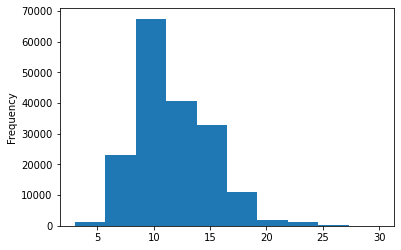

In [14]:
train_df['total_lines'].plot.hist()

##Convert labels to numeric datatype

###One hot encoding

In [15]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_onehot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))

In [16]:
train_labels_onehot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [17]:
valid_labels_onehot = one_hot_encoder.transform(valid_df['target'].to_numpy().reshape(-1, 1))
test_labels_onehot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

###Label encoding

In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(valid_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [19]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
train_sentences = train_df['text'].tolist()
val_sentences = valid_df['text'].tolist()
test_sentences = test_df['text'].tolist()

#Model 0- Naive Bayes

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ('tf-idf', TfidfVectorizer()),
                    ('clf', MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [22]:
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [23]:
model_0_preds = model_0.predict(val_sentences)
model_0_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-20 10:14:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-20 10:14:53 (84.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
from helper_functions import calculate_results

model_0_results = calculate_results(val_labels_encoded, model_0_preds)
model_0_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

#Tokenization
Its done so that we can use train data for next deep learning models

In [26]:
import tensorflow as tf
from tensorflow.keras import layers

##Get avg len of each sentence

In [27]:
sentence_len = [len(sentence.split()) for sentence in train_sentences] # for each sentence, split it into words. find len of the list of words so obtained to get total words
avg_sent_len = np.mean(sentence_len) # find mean words per sentence
avg_sent_len

26.338269273494777

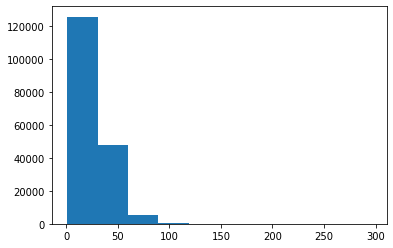

In [28]:
import matplotlib.pyplot as plt
plt.hist(sentence_len);

In [29]:
np.percentile(sentence_len, 95) # get max len of 95% of sentences

55.0

In [30]:
output_seq_len = int(np.percentile(sentence_len, 95))
output_seq_len

55

In [31]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens = 68000
text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len)

text_vectorizer.adapt(train_sentences)

In [32]:
# Choose a random sentence from the training dataset and tokenize it
import random
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
pain intensity was assessed with an electronic visual analog scale ( evas ) .        

Vectorized version:


<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[   65,   579,    10,   113,     7,    26,  2014,   290,   973,
          158, 58319,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])>

In [33]:
# find most common and least common words in dictionary
rct_20k_vocab = text_vectorizer.get_vocabulary()

print(f'Number of words: {len(rct_20k_vocab)}')
print(f'Most used words: {rct_20k_vocab[:5]}')
print(f'Least used words: {rct_20k_vocab[-5:]}')

Number of words: 64841
Most used words: ['', '[UNK]', 'the', 'and', 'of']
Least used words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


#Embedding layer

In [34]:
token_embedding = layers.Embedding(input_dim = len(rct_20k_vocab),
                                   output_dim = 128, # if we keep output_dim low, then it wont be able catch the relations. if we keep it high then model would take time to compile
                                   mask_zero = True, # use masking to handle variable sequence lengths (save space)
                                   name = 'token_embedding')


In [35]:
random_sentence = random.choice(train_sentences)
print(f'Original sentence: {random_sentence}')
print(f'length: {len(random_sentence)}')
tokenised_sent = text_vectorizer(random_sentence) # convert sentence into tokens. no. of tokens = 55
print(f'Textvectorization: {tokenised_sent}')
print(f'shape: {tokenised_sent.shape}')
embeded_sent = token_embedding(tokenised_sent) # embed the token. each token is represented by 128 num. thus shape=(55,128)
print(f'Embedding: {embeded_sent}')
print(f'shape: {embeded_sent.shape}')

Original sentence: no or minimal changes in customer behaviors were observed after a @-month implementation period .
length: 97
Textvectorization: [   33    16  1293   146     5 23454   987     9   148    21     8   178
   754   173     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
shape: (55,)
Embedding: [[-0.03971631 -0.02191653  0.00720228 ...  0.0153097  -0.02148311
  -0.01733841]
 [ 0.0279405  -0.01099676 -0.045348   ...  0.04845366  0.00883528
  -0.01422935]
 [-0.04913396  0.04547988  0.04703554 ...  0.00484987 -0.01929867
  -0.03679759]
 ...
 [-0.00214014  0.01385546 -0.02900424 ... -0.03333391  0.01639969
  -0.02308615]
 [-0.00214014  0.01385546 -0.02900424 ... -0.03333391  0.01639969
  -0.02308615]
 [-0.00214014  0.01385546 -0.02900424 ... -0.03333391  0.01639969
  -0.02308615]]
s

#Making datasets
this is done so that our data can run as fast as possible

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_onehot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, valid_labels_onehot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_onehot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [37]:
# turning the datasets into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#Model 1: Conv1d with token embeddings

In [38]:
len(train_labels_onehot[0])

5

In [39]:
num_classes = len(train_labels_onehot[0])

In [40]:
# Create model
inputs = layers.Input(shape = (1, ), dtype = tf.string)
text_vectorization = text_vectorizer(inputs)
embeddings = token_embedding(text_vectorization)
x = layers.Conv1D(64, kernel_size=5, padding = 'same', activation='relu')(embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)), # fitted on only 10% of data for faster training time
                              epochs=3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset))) # validate on 10% of data

Epoch 1/3
562/562 [==============================] - 39s 14ms/step - loss: 0.9068 - accuracy: 0.6408 - val_loss: 0.6756 - val_accuracy: 0.7440
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6563 - accuracy: 0.7565 - val_loss: 0.6238 - val_accuracy: 0.7756
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6188 - accuracy: 0.7727 - val_loss: 0.5960 - val_accuracy: 0.7859


In [41]:
 model_1.evaluate(valid_dataset) # validate on entire dataset

945/945 [==============================] - 5s 5ms/step - loss: 0.6006 - accuracy: 0.7861


[0.6005594730377197, 0.7860783934593201]

In [42]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.1431761e-01, 1.9635698e-01, 1.0359958e-01, 2.5501671e-01,
        3.0709149e-02],
       [4.8491246e-01, 2.3537789e-01, 1.6686989e-02, 2.5560597e-01,
        7.4167759e-03],
       [1.4167160e-01, 5.7778922e-03, 1.2860249e-03, 8.5124004e-01,
        2.4422950e-05],
       ...,
       [3.1525838e-06, 5.4165354e-04, 5.2949844e-04, 2.1938695e-06,
        9.9892348e-01],
       [6.0711790e-02, 4.0499026e-01, 1.2572667e-01, 7.2051376e-02,
        3.3651993e-01],
       [1.5908656e-01, 6.8385565e-01, 2.8689155e-02, 4.3293331e-02,
        8.5075274e-02]], dtype=float32)

In [43]:
model_1_pred = tf.argmax(model_1_pred_probs, axis=1)
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [44]:
model_1_results = calculate_results(y_true = val_labels_encoded, y_pred = model_1_pred)
model_1_results

{'accuracy': 78.60783794518734,
 'f1': 0.7836077582338354,
 'precision': 0.7825621015236868,
 'recall': 0.7860783794518734}

#Model 2: Feature extraction with Universal Sentence Encoder(USE)

##Trying USE

In [45]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer(handle = "https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False, 
                                        name = 'universal_sentence_encoder')

In [46]:
random_sentence = random.choice(train_sentences)
print(f'text: {random_sentence}')
random_sentence_embedded = tf_hub_embedding_layer([random_sentence])
random_sentence_embedded

text: in addition , both groups received regular rehabilitation which included flexibility , strength , balance , self care and functional training .


<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-5.91993518e-02, -7.09351152e-02, -5.42480089e-02,
         4.71094847e-02,  1.98097974e-02,  8.09460357e-02,
        -3.06517351e-02, -2.24248413e-02, -2.57293712e-02,
         5.45472242e-02,  3.12040541e-02, -4.79192398e-02,
        -1.62866991e-02, -2.05397885e-02,  4.32472350e-03,
        -1.91326514e-02, -4.90806550e-02,  7.80405551e-02,
        -1.13552641e-02,  1.76574402e-02, -2.35418556e-03,
         6.18573651e-02, -1.66590456e-02, -3.35004255e-02,
         4.86793667e-02,  7.95257371e-03, -1.62941702e-02,
         2.96552889e-02,  4.64398637e-02, -3.88880782e-02,
         1.95404980e-02,  8.28997046e-02, -3.91352028e-02,
         6.15577176e-02, -6.48727044e-02,  1.20366644e-02,
         7.21108466e-02, -5.27318828e-02, -5.92528516e-03,
         5.63126896e-03, -6.66271076e-02,  7.40152644e-03,
         5.06250858e-02,  4.45181690e-02,  4.14847173e-02,
        -4.61426713e-02, -8.81419796e-03,  2.99884602e-02,
      

##Make model

In [47]:
# building model
inputs = layers.Input(shape=[], dtype = tf.string) # USE expects input as list of strings
feature_extract_embedding = tf_hub_embedding_layer(inputs) # use the USE to make an embedding of whole sequence(not tokens) in a 512 long vector
x = layers.Dense(128, activation='relu')(feature_extract_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [48]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [49]:
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 22ms/step - loss: 0.9176 - accuracy: 0.6485 - val_loss: 0.7997 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 11s 20ms/step - loss: 0.7709 - accuracy: 0.7015 - val_loss: 0.7561 - val_accuracy: 0.7074
Epoch 3/3
562/562 [==============================] - 11s 20ms/step - loss: 0.7526 - accuracy: 0.7108 - val_loss: 0.7375 - val_accuracy: 0.7161


In [50]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.7410 - accuracy: 0.7149


[0.7410473823547363, 0.7149477005004883]

In [51]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred = tf.argmax(model_2_pred_probs, axis=1)
model_2_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [52]:
model_2_results = calculate_results(val_labels_encoded, model_2_pred)
model_2_results

{'accuracy': 71.49477028995102,
 'f1': 0.7119627154907895,
 'precision': 0.716096660652787,
 'recall': 0.7149477028995102}

#Model 3- Conv1d with character embedding
Using character embedding instead of token embedding

##Creating character level tokenizer

In [53]:
list(random_sentence)

['i',
 'n',
 ' ',
 'a',
 'd',
 'd',
 'i',
 't',
 'i',
 'o',
 'n',
 ' ',
 ',',
 ' ',
 'b',
 'o',
 't',
 'h',
 ' ',
 'g',
 'r',
 'o',
 'u',
 'p',
 's',
 ' ',
 'r',
 'e',
 'c',
 'e',
 'i',
 'v',
 'e',
 'd',
 ' ',
 'r',
 'e',
 'g',
 'u',
 'l',
 'a',
 'r',
 ' ',
 'r',
 'e',
 'h',
 'a',
 'b',
 'i',
 'l',
 'i',
 't',
 'a',
 't',
 'i',
 'o',
 'n',
 ' ',
 'w',
 'h',
 'i',
 'c',
 'h',
 ' ',
 'i',
 'n',
 'c',
 'l',
 'u',
 'd',
 'e',
 'd',
 ' ',
 'f',
 'l',
 'e',
 'x',
 'i',
 'b',
 'i',
 'l',
 'i',
 't',
 'y',
 ' ',
 ',',
 ' ',
 's',
 't',
 'r',
 'e',
 'n',
 'g',
 't',
 'h',
 ' ',
 ',',
 ' ',
 'b',
 'a',
 'l',
 'a',
 'n',
 'c',
 'e',
 ' ',
 ',',
 ' ',
 's',
 'e',
 'l',
 'f',
 ' ',
 'c',
 'a',
 'r',
 'e',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 'f',
 'u',
 'n',
 'c',
 't',
 'i',
 'o',
 'n',
 'a',
 'l',
 ' ',
 't',
 'r',
 'a',
 'i',
 'n',
 'i',
 'n',
 'g',
 ' ',
 '.']

In [54]:
def split_into_char(text):
  return " ".join(list(text)) # split the text into each char and then join each char by " ". this creates a string of char seperated by " ", similar to string of words seperated by " "

split_into_char(random_sentence)

'i n   a d d i t i o n   ,   b o t h   g r o u p s   r e c e i v e d   r e g u l a r   r e h a b i l i t a t i o n   w h i c h   i n c l u d e d   f l e x i b i l i t y   ,   s t r e n g t h   ,   b a l a n c e   ,   s e l f   c a r e   a n d   f u n c t i o n a l   t r a i n i n g   .'

In [55]:
# create train, valid and test char datasets
train_chars = [split_into_char(sentence) for sentence in train_sentences]
valid_chars = [split_into_char(sentence) for sentence in val_sentences]
test_chars = [split_into_char(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [56]:
len(random_sentence) # gives num of char in a random sentence

143

Get avg char per sentence

Average characters: 149.3662574983337


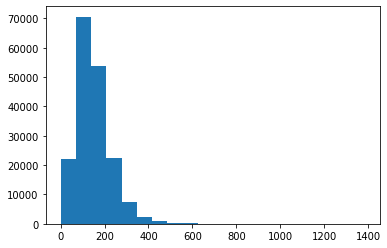

In [57]:
chars_in_sentence = [len(sentence) for sentence in train_sentences]
avg_chars = np.mean(chars_in_sentence)
print(f'Average characters: {avg_chars}')
plt.hist(chars_in_sentence, bins=20);

In [58]:
output_seq_char_len = int(np.percentile(chars_in_sentence, 95))
output_seq_char_len

290

Get number of diff char possible

In [59]:
import string

alphabets = string.ascii_lowercase + string.digits + string.punctuation
alphabets

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [60]:
num_diff_char = len(alphabets) + 2 # 1 for ' ' and other for OOV(out of vocab(UNK))

Char vectorizer

In [61]:
char_vectorizer = TextVectorization(max_tokens=num_diff_char,
                                    output_sequence_length = output_seq_char_len,
                                    name = 'char_vectorizer')


In [62]:
char_vectorizer.adapt(train_chars)

In [63]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [64]:
# Test out char vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t o   e x a m i n e   t h e   a s s o c i a t i o n   b e t w e e n   m e a s u r e s   o f   a r t e r i a l   s t i f f n e s s   a n d   c h a n g e   i n   a   d e p o s i t i o n   o v e r   t i m e   .

Length of random_train_chars: 88

Vectorized chars:
 [[ 3  7  2 24  5 15  4  6  2  3 13  2  5  9  9  7 11  4  5  3  4  7  6 22
   2  3 20  2  2  6 15  2  5  9 16  8  2  9  7 17  5  8  3  2  8  4  5 12
   9  3  4 17 17  6  2  9  9  5  6 10 11 13  5  6 18  2  4  6  5 10  2 14
   7  9  4  3  4  7  6  7 21  2  8  3  4 15  2  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

##Character level embedding layer

In [65]:
char_embedding = layers.Embedding(input_dim=len(char_vocab),
                                  output_dim = 25, # 25
                                  mask_zero = True,
                                  name = 'char_embed')

In [66]:

# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embedding(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 t o   e x a m i n e   t h e   a s s o c i a t i o n   b e t w e e n   m e a s u r e s   o f   a r t e r i a l   s t i f f n e s s   a n d   c h a n g e   i n   a   d e p o s i t i o n   o v e r   t i m e   .

Embedded chars (after vectorization and embedding):
 [[[-0.02722991  0.02884376 -0.02537875 ...  0.00042943  0.03422037
   -0.04808591]
  [-0.04979446  0.03366264 -0.02665002 ...  0.04356101  0.00922719
    0.00588821]
  [-0.03539594 -0.04489001  0.03612814 ... -0.04356469 -0.02439231
   -0.03974128]
  ...
  [ 0.01506941  0.03161848  0.01718209 ...  0.00061877 -0.00349391
   -0.0060593 ]
  [ 0.01506941  0.03161848  0.01718209 ...  0.00061877 -0.00349391
   -0.0060593 ]
  [ 0.01506941  0.03161848  0.01718209 ...  0.00061877 -0.00349391
   -0.0060593 ]]]

Character embedding shape: (1, 290, 25)


In [67]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((valid_chars, valid_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset= tf.data.Dataset.from_tensor_slices((test_chars, test_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)

##Creating Conv1D Model

In [68]:
inputs = layers.Input(shape = (1, ), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
embedding_data = char_embedding(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation = 'relu')(embedding_data)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_3 = tf.keras.Model(inputs, outputs)

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [69]:
# Fit model
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=valid_char_dataset,
                              validation_steps=int(0.1*len(valid_char_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 10ms/step - loss: 1.2472 - accuracy: 0.4961 - val_loss: 1.0438 - val_accuracy: 0.5898
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 1.0147 - accuracy: 0.5959 - val_loss: 0.9528 - val_accuracy: 0.6154
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.9452 - accuracy: 0.6286 - val_loss: 0.8839 - val_accuracy: 0.6592


In [70]:
model_3.evaluate(valid_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.9040 - accuracy: 0.6493


[0.9040401577949524, 0.6493446230888367]

In [71]:
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred = tf.argmax(model_3_pred_probs, axis=1)
model_3_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [72]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_pred)
model_3_results

{'accuracy': 64.93446312723421,
 'f1': 0.6400917411565754,
 'precision': 0.6424781623212452,
 'recall': 0.6493446312723421}

#Model 4 - Combining token embeddings + char embeddings

Steps-
1. Create token embedding model
2. Create char emebedding model
3. Combine the 2 models
4. Add layers on top of the combined model
5. Create the whole model

##Creating model

###1. Create token embedding model


In [73]:
# similar to done abv
token_inputs = layers.Input(shape = [], dtype = tf.string, name = 'token_input') # shape = [] - cause we have used USE
token_embed = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(units = 128, activation = 'relu')(token_embed)
token_model = tf.keras.Model(token_inputs, token_outputs)

###2. Create char embedding model

In [74]:
char_inputs = layers.Input(shape = (1, ), dtype = tf.string, name = 'char_input') # our custom token, char embeddings would have shape = (1, )
char_vector = char_vectorizer(char_inputs) # custom token and char inputs in their datasets are in tuples of shape (1, x, y) - here 1 indicates 1 tuple - not sure
char_embed = char_embedding(char_vector)
char_outputs = layers.Bidirectional(layers.LSTM(24))(char_embed)
char_model = tf.keras.Model(char_inputs, char_outputs)

###3. Concatenate the 2 models

In [75]:
token_char_concat = layers.Concatenate(name = 'toke_char_concat')([token_model.output, char_model.output])

###4. Add layers on top

In [76]:
# Adding a dropout layer 
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.1)(combined_dense)
output_layer = layers.Dense(num_classes, activation = 'softmax')(final_dropout)


###5. Create whole model

In [77]:
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input], outputs = output_layer,
                         name = 'model_4_token_char_concat')

In [78]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

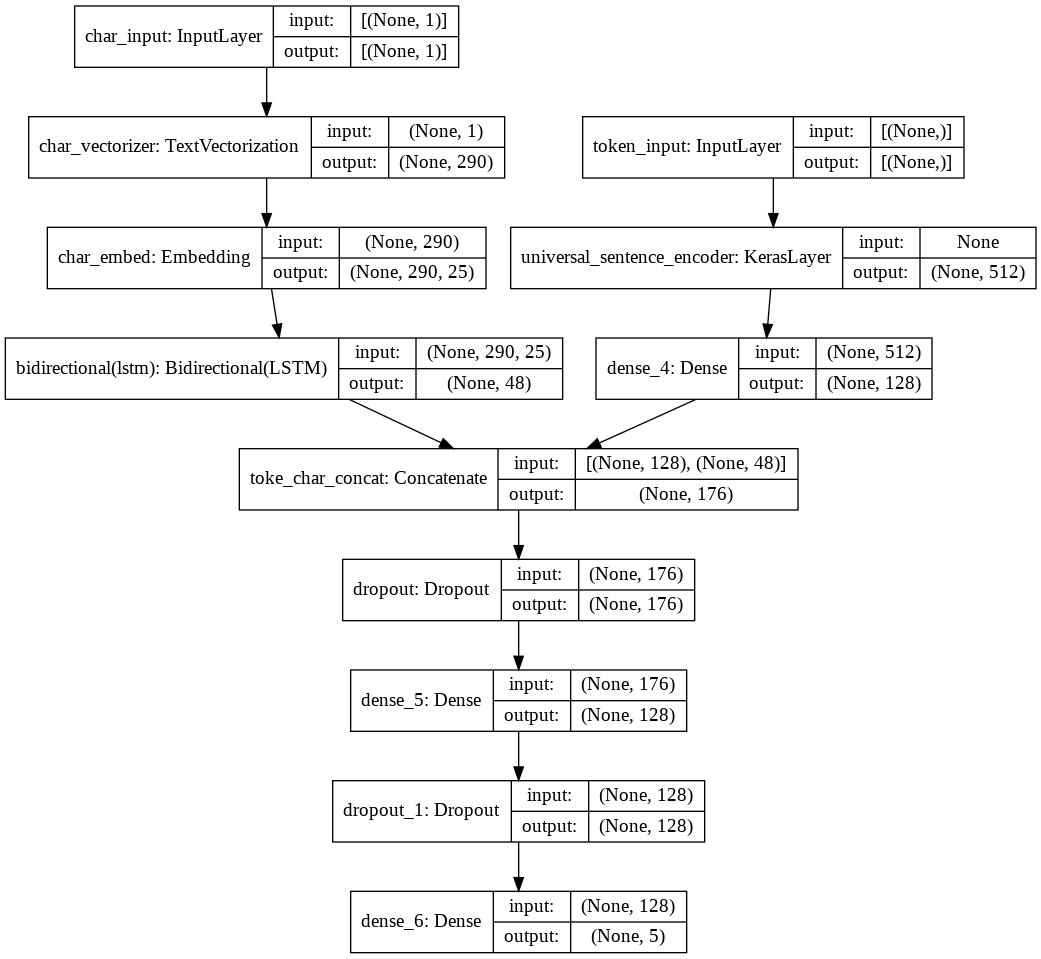

In [79]:
# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
plot_model(model_4, show_shapes=True)

## Make datasets

The order of inputs should be imp. In our concat model, we have put token_model b4 char model. so in the new dataset, token_data shuld be b4 char_data

In [80]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make train data
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_onehot) # make train labels
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels)) # combine train data and labels just like for other models

train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
# Repeat the above steps for our validation data
valid_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, valid_chars)) # make data
valid_token_char_labels = tf.data.Dataset.from_tensor_slices(valid_labels_onehot) # make labels
valid_token_char_dataset = tf.data.Dataset.zip((valid_token_char_data, valid_token_char_labels)) # combine data and labels
valid_token_char_dataset = valid_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [82]:
# Check out our training char and token embedding dataset
train_token_char_dataset, valid_token_char_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

##Fitting and evaluating model

In [83]:
model_4_history = model_4.fit(train_token_char_dataset, 
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_token_char_dataset)),
                              validation_data = valid_token_char_dataset,
                              validation_steps = int(0.1 * len(valid_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 85s 134ms/step - loss: 0.9318 - accuracy: 0.6336 - val_loss: 0.7694 - val_accuracy: 0.6995
Epoch 2/3
562/562 [==============================] - 73s 129ms/step - loss: 0.7703 - accuracy: 0.6999 - val_loss: 0.7060 - val_accuracy: 0.7324
Epoch 3/3
562/562 [==============================] - 68s 122ms/step - loss: 0.7492 - accuracy: 0.7114 - val_loss: 0.6779 - val_accuracy: 0.7450


In [84]:
model_4.evaluate(valid_token_char_dataset)

945/945 [==============================] - 50s 53ms/step - loss: 0.6850 - accuracy: 0.7398


[0.6849868297576904, 0.7397722601890564]

In [85]:
model_4_pred_probs = model_4.predict(valid_token_char_dataset)
model_4_pred = tf.argmax(model_4_pred_probs, axis=1)

In [86]:
model_4_results = calculate_results(val_labels_encoded, model_4_pred)
model_4_results

{'accuracy': 73.97722759168542,
 'f1': 0.7377078257603908,
 'precision': 0.740298791587926,
 'recall': 0.7397722759168542}

#Model 5 - Model with token + char + positional embeddings

In [87]:
# for positional embeddings we are going to use the position of lines(line num) and number of lines in para to find patterns
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

(array([4.5000e+04, 4.4941e+04, 4.2383e+04, 2.9914e+04, 1.2840e+04,
        3.8000e+03, 9.1000e+02, 2.0000e+02, 4.3000e+01, 9.0000e+00]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

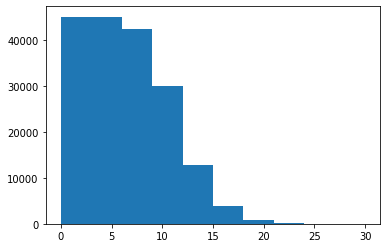

In [88]:
plt.hist(train_df['line_number'])

##One hot encoding the positional features

In [89]:
# most of the line numbers are b/w 0-15. we can ignore the others as they are less in freq when compared to line numbers with higher freq
# thus we take depth of onehot as 15
train_line_num_onehot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
valid_line_num_onehot = tf.one_hot(valid_df['line_number'].to_numpy(), depth=15)
test_line_num_onehot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_line_num_onehot[:14], train_line_num_onehot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [90]:
# now we do the same for the total lines feature
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

(array([ 1393., 23102., 67507., 40551., 32807., 11026.,  2051.,  1223.,
          291.,    89.]),
 array([ 3. ,  5.7,  8.4, 11.1, 13.8, 16.5, 19.2, 21.9, 24.6, 27.3, 30. ]),
 <a list of 10 Patch objects>)

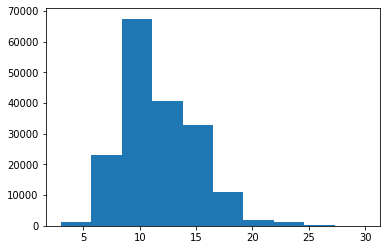

In [91]:
plt.hist(train_df['total_lines'])

In [92]:
# find whats the max number of total lines for 95%
np.percentile(train_df['total_lines'], 95)

18.0

In [93]:
train_total_lines_onehot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
valid_total_lines_onehot = tf.one_hot(valid_df['total_lines'].to_numpy(), depth=20)
test_total_lines_onehot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

In [94]:
train_total_lines_onehot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

##Creating the model
1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

###1.Create token-lvl model

In [95]:
token_inputs = layers.Input(shape=[], dtype = tf.string, name = 'token_inputs')
token_embed = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = 'relu')(token_embed)
token_model = tf.keras.Model(token_inputs, token_outputs)

###2.Create char-lvl model

In [96]:
char_inputs = layers.Input(shape=(1, ), dtype = tf.string, name = 'char_inputs')
char_vector = char_vectorizer(char_inputs)
char_embed = char_embedding(char_vector)
char_outputs = layers.Bidirectional(layers.LSTM(24))(char_embed)
char_model = tf.keras.Model(char_inputs, char_outputs)

###3.'line_num' model

In [97]:
line_num_input = layers.Input(shape = (15, ), dtype = tf.float32, name = 'line_num_input') # input shape = 15 cause the line_num feature was onehot encoded into feature vectors of depth 15
x = layers.Dense(32, activation = 'relu')(line_num_input)
line_num_model = tf.keras.Model(line_num_input, x)

###4.'total_lines' model

In [98]:
total_lines_input = layers.Input(shape = (20, ), dtype = tf.float32, name = 'total_lines_input') # input shape = 20 cause the total_lines feature was onehot encoded into feature vectors of depth 20
y = layers.Dense(32, activation = 'relu')(total_lines_input)
total_lines_model = tf.keras.Model(total_lines_input, y)

###5. Combine token and char lvl embeddings

In [99]:
combined_embedding = layers.Concatenate(name = 'token_char_concat')([token_model.output, char_model.output])

z = layers.Dense(256, activation = 'relu')(combined_embedding)
z = layers.Dropout(0.5)(z)

###6. Combine the line_num, total_lines, combined_embedding model

In [100]:
tribrid_embeddings = layers.Concatenate(name = 'token_char_positional_embedding')([line_num_model.output, total_lines_model.output, 
                                                                                 z]) # z isnt a model. so its data is output


###7.Create an output layer to accept the tribrid embedding and output label probabilities

In [101]:
output_layer = layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')(tribrid_embeddings)

###8.Combine the inputs of diff models and outputs of into a Model

In [102]:
model_5 = tf.keras.Model(inputs = [line_num_model.input, total_lines_model.input, token_model.input, char_model.input], # give inputs in the same order that the models were concatenated
                         outputs = output_layer,
                         name = 'model_5_tribrid_embedding_model')

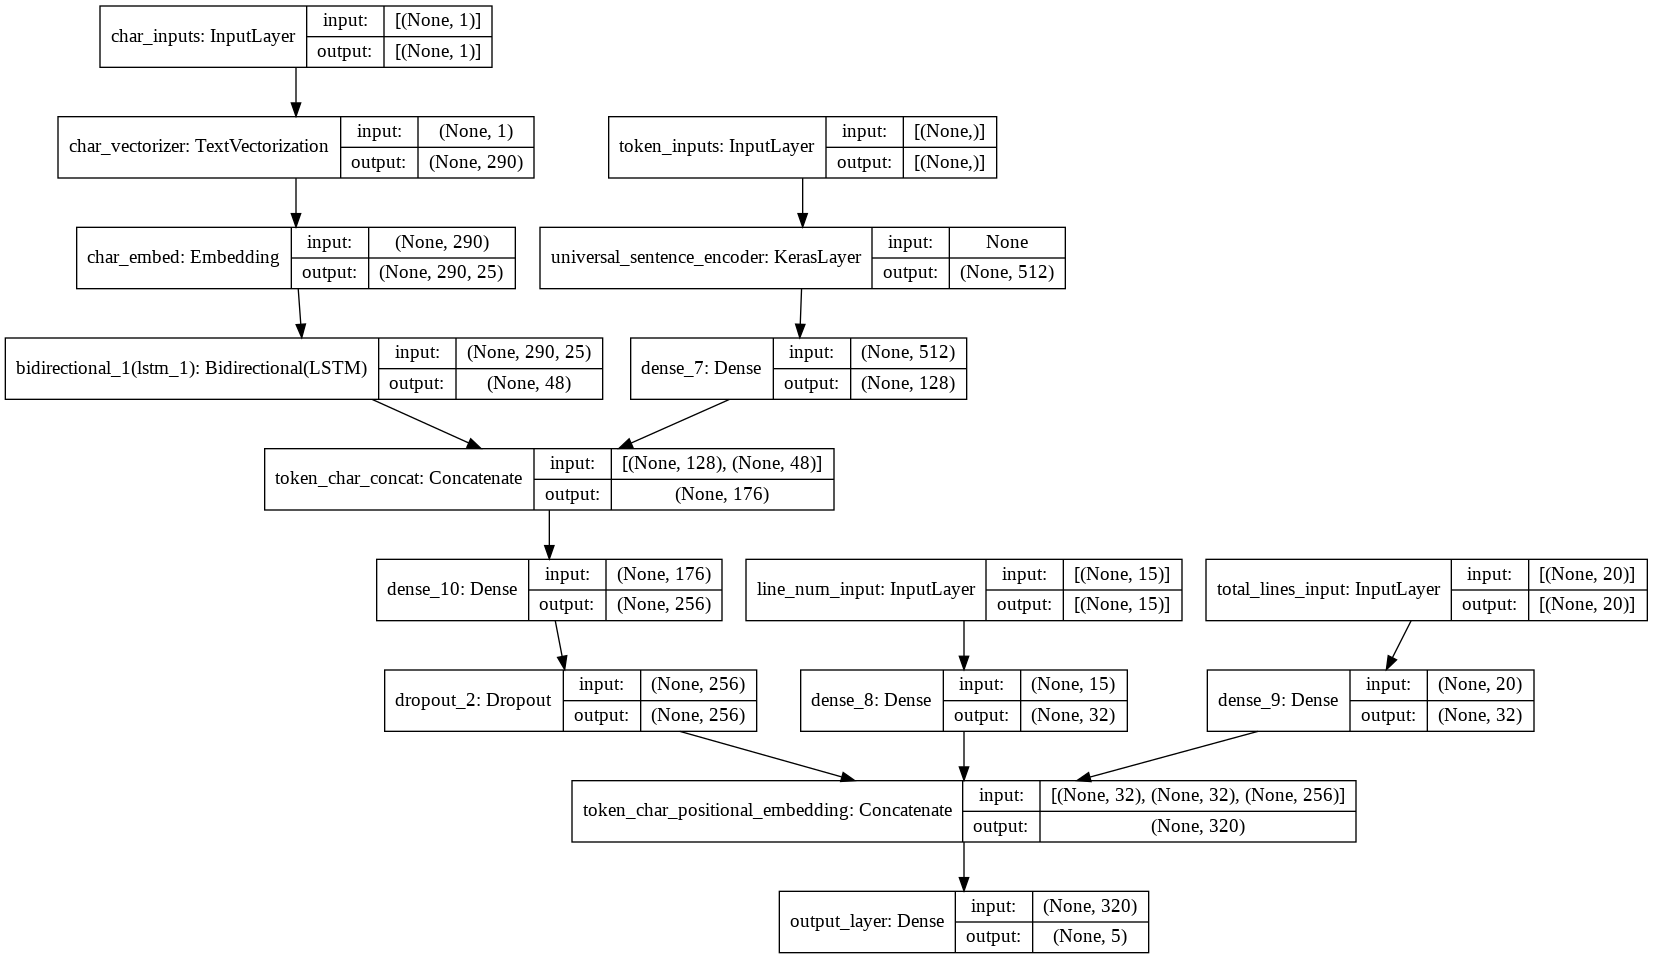

In [103]:
# Plot model_5 to explore it visually...
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

##Compile Model

In [104]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # label smoothing is done to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

##Creating datasets

In [105]:
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_num_onehot, train_total_lines_onehot, train_sentences, train_chars))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_onehot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels))
train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [106]:
valid_tribrid_data = tf.data.Dataset.from_tensor_slices((valid_line_num_onehot, valid_total_lines_onehot, val_sentences, valid_chars))
valid_tribrid_labels = tf.data.Dataset.from_tensor_slices(valid_labels_onehot)
valid_tribrid_dataset = tf.data.Dataset.zip((valid_tribrid_data, valid_tribrid_labels))
valid_tribrid_dataset = valid_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [107]:
train_tribrid_dataset, valid_tribrid_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

##Fit and evaluate model

In [108]:
model_5_history = model_5.fit(train_tribrid_dataset,
                              epochs=3,
                              steps_per_epoch = int(0.1 * len(train_tribrid_dataset)),
                              validation_data = valid_tribrid_dataset,
                              validation_steps = int(0.1 * len(valid_tribrid_dataset)))

Epoch 1/3
562/562 [==============================] - 88s 138ms/step - loss: 1.0995 - accuracy: 0.7203 - val_loss: 0.9783 - val_accuracy: 0.8012
Epoch 2/3
562/562 [==============================] - 75s 133ms/step - loss: 0.9648 - accuracy: 0.8175 - val_loss: 0.9484 - val_accuracy: 0.8308
Epoch 3/3
562/562 [==============================] - 70s 124ms/step - loss: 0.9498 - accuracy: 0.8247 - val_loss: 0.9373 - val_accuracy: 0.8321


In [109]:
model_5.evaluate(valid_tribrid_dataset)

945/945 [==============================] - 52s 55ms/step - loss: 0.9356 - accuracy: 0.8340


[0.935646116733551, 0.8340063691139221]

In [110]:
model_5_pred_probs = model_5.predict(valid_tribrid_dataset)
model_5_pred = tf.argmax(model_5_pred_probs, axis=1)
model_5_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [111]:
model_5_results = calculate_results(val_labels_encoded, model_5_pred)
model_5_results

{'accuracy': 83.40063550906925,
 'f1': 0.8331733490675989,
 'precision': 0.8333029356797017,
 'recall': 0.8340063550906924}

#Comparing Model Results

In [112]:
all_model_results = pd.DataFrame({'Model_0_baseline': model_0_results,
                                  'Model_1_custom_token_embedding': model_1_results,
                                  'Model_2_USE': model_2_results,
                                  'Model_3_char_embedding': model_3_results,
                                  'Model_4_token_and_char_embedding': model_4_results,
                                  'Model_5_positional_token_char_embedding': model_5_results})
all_model_results.transpose()


,accuracy,precision,recall,f1
Model_0_baseline,72.183238,0.718647,0.721832,0.698925
Model_1_custom_token_embedding,78.607838,0.782562,0.786078,0.783608
Model_2_USE,71.494770,0.716097,0.714948,0.711963
Model_3_char_embedding,64.934463,0.642478,0.649345,0.640092
Model_4_token_and_char_embedding,73.977228,0.740299,0.739772,0.737708
Model_5_positional_token_char_embedding,83.400636,0.833303,0.834006,0.833173


In [113]:
all_model_results = all_model_results.transpose()

In [114]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

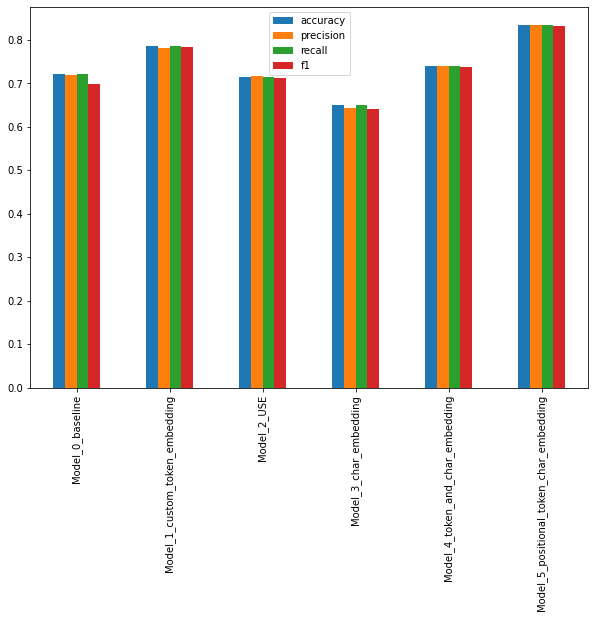

In [115]:
all_model_results.plot(kind = 'bar', figsize = (10,7))

#Save Model

In [116]:
model_5.save('skimlit_tribrid_model')

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


#Evaluate model

##Create test dataset

In [119]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_num_onehot,
                                                               test_total_lines_onehot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_onehot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

##Evaluate

In [120]:
test_pred_probs = model_5.predict(test_pos_char_token_dataset)

In [122]:
test_pred = tf.argmax(test_pred_probs, axis=1)
test_pred[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0])>

In [123]:
#get results
model_5_test_results = calculate_results(test_labels_encoded, test_pred)
model_5_test_results

{'accuracy': 82.95337647254023,
 'f1': 0.8285841067369256,
 'precision': 0.8285437140813001,
 'recall': 0.8295337647254023}

In [124]:
model_5_test_results

{'accuracy': 82.95337647254023,
 'f1': 0.8285841067369256,
 'precision': 0.8285437140813001,
 'recall': 0.8295337647254023}

#Make predictions on data

##Get data

In [126]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
import json
with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2021-09-20 11:23:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.1’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2021-09-20 11:23:05 (67.7 MB/s) - ‘skimlit_example_abstracts.json.1’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'details': 'RCT of a manualized social treatment for high-functioning autism spectrum 

In [127]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


##Seperate into sentences

In [128]:
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

##Get line number and number of lines, create a dict

In [129]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'line_number': 0,
  'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'total_lines': 7},
 {'line_number': 1,
  'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'total_lines': 7},
 {'line_number': 2,
  'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'total_lines': 7},
 {'line_number': 3,
  'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'total_lines': 7},
 {'line_number': 4,
  'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'total_lines': 7},
 {'line_number': 5,
  'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'total_lines': 7},
 {'line_

##One hot line_num and total_lines

In [130]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [131]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

##Split into char

In [133]:
# Split abstract lines into characters
abstract_chars = [split_into_char(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

##Evaluate

In [134]:
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

array([[0.30007797, 0.12034187, 0.01596319, 0.53794754, 0.02566937],
       [0.09416302, 0.02810828, 0.69089013, 0.10763458, 0.07920396],
       [0.13616025, 0.04584109, 0.57864046, 0.16208167, 0.07727647],
       [0.11888412, 0.14247726, 0.5172617 , 0.08588931, 0.13548763],
       [0.06232412, 0.10147522, 0.3801426 , 0.05673606, 0.39932206],
       [0.04219433, 0.11457563, 0.53671086, 0.04899425, 0.25752488],
       [0.02607919, 0.16042604, 0.07840072, 0.02340276, 0.7116913 ],
       [0.01972264, 0.09700225, 0.20331788, 0.03501499, 0.6449423 ]],
      dtype=float32)

In [135]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [136]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [137]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
